# APS - Trabajo final

# Consideraciones generales:     ⬇         LEER.  ⬇



*  ✅ Cada grupo descarga la señal que le corresponda que estarán subidas al
campus y las sube al colab


*  ✅ Se entrega el trabajo subiendo este  archivo colab al campus indicando Nro de grupo e integrantes.


* ✅ Es imprescindible ir contando que van haciendo, cómo y por qué usan tal herramienta. Los gráficos deben tener títulos y labels



* ✅ Cualquier inconveniente técnico con la señal escriban a aaragon@unsam.edu.ar (antes del martes 14 )

* ✅ La entrega cierra el jueves 16 a las 23:00hs. **No podemos atrasarnos**













---

---



---





Son señales de ECG, tal como trabajamos en clase.
vamos a trabajar con raw[1,:]
La frecuencia de muestreo es de 400 Hz.

Este trabajo tiene 3 partes.

**PARTE 1**

In [2]:
# para subir el archivo
from google.colab import files
file = files.upload()
fname = next(iter(file))

Saving ECG17.mat to ECG17.mat


In [468]:
import scipy.io
mat = scipy.io.loadmat('ECG17.mat')
raw = mat['val']
ecg_signal=raw[0,:]

Imprimir el tamaño de la señal

In [469]:
cant_muest = len(ecg_signal)
print(f'Tamaño de la señal: {cant_muest}')

Tamaño de la señal: 5000


Definir vector de tiempo, calcular e imprimir la duración de la señal  y el dt (paso) y graficar la señal sabiendo que la misma fue muestreada a 400Hz

El valor de tf es: 12.5 segundos.
El valor del dt es: 0.0025 segundos por muestra.


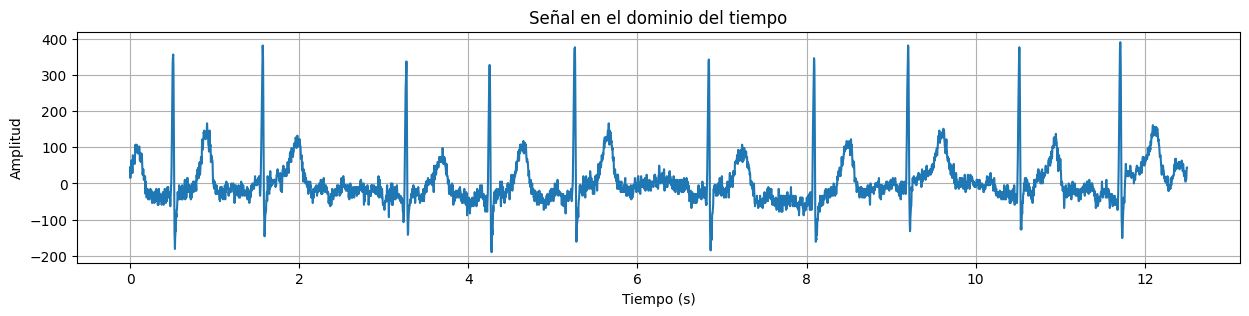

In [490]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from numpy.fft import fft, ifft


"""
Defino los parametros de la señal necesarios para el array de tiempo
y luego ploteo ECG vs t.
"""

freq_muest = 400
ti = 0
tf = cant_muest / freq_muest
dt = 1. /freq_muest

t = np.arange(ti, tf, dt)

print(f"El valor de tf es: {tf} segundos.")
print(f"El valor del dt es: {dt} segundos por muestra.")

plt.figure(figsize=(15, 3))
plt.plot(t, ecg_signal)
plt.title('Señal en el dominio del tiempo')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid(True)
plt.show()

Hallar espectro de frecuencias y espectrograma para  detectar frecuencias no deseadas

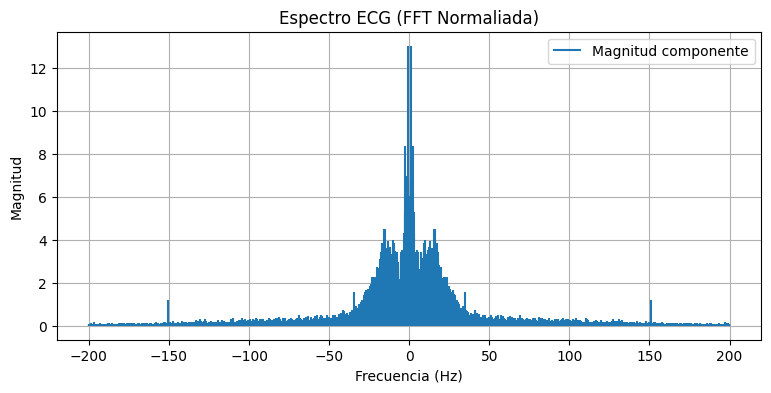

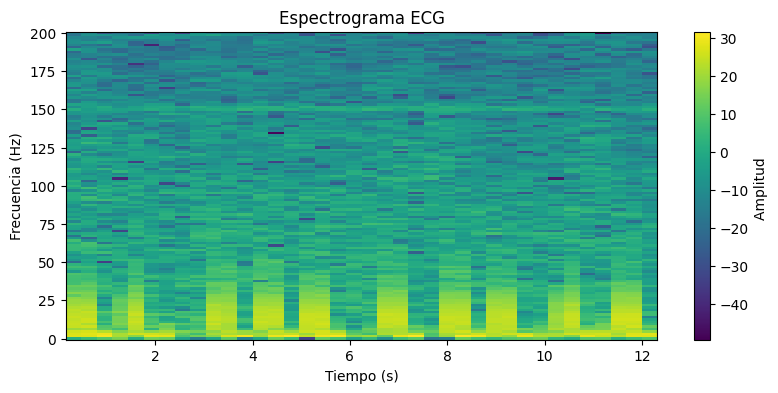

In [494]:
def plot_fft(ecg_signal, cant_muest, dt, xlim = None):
  """
  Imprime el espectro de una señal con xlim pasado como argumento opcional
  """
  # Obtengo las magnitudes y sus componentes frecuenciales
  ecg_signal_fft = np.fft.fft(ecg_signal) / cant_muest  # Normalizo por la longitud de la señal
  ecg_signal_freq = np.fft.fftfreq(len(ecg_signal), dt)

  # Espectro FFT
  plt.figure(figsize=(20, 4))
  plt.subplot(1, 2, 1)
  plt.vlines(ecg_signal_freq, 0, np.abs(ecg_signal_fft), label='Magnitud componente')
  plt.title('Espectro ECG (FFT Normaliada)')
  plt.xlabel('Frecuencia (Hz)')
  plt.ylabel('Magnitud')
  plt.xlim(0, xlim) if xlim is not None else None   # Si no se especifica imprime espectro entero
  plt.legend()
  plt.grid(True)
  plt.show()


def plot_Sxx(ecg_signal, cant_muest, dt, ylim = None):
  """
  Imprime el espectrograma de la señal cono ylim con argumento opcional
  """

  nperseg = 256  # Tamaño de la ventana
  noverlap = nperseg // 2  # Superposición entre ventanas

  # Obtengo magnitudes y componentes espectrales y temporales
  freq_Sxx, t_Sxx, Sxx = signal.spectrogram(ecg_signal, fs=1/dt, nperseg=256, noverlap=noverlap, scaling='density')

  #Espectrograma
  plt.figure(figsize=(21, 4))
  plt.subplot(1, 2, 2)

  #En dB para observar mejor los cambios
  plt.pcolormesh(t_Sxx, freq_Sxx, 10 * np.log10(Sxx), shading='auto')
  plt.title('Espectrograma ECG')
  plt.xlabel('Tiempo (s)')
  plt.ylabel('Frecuencia (Hz)')
  plt.ylim(0, ylim) if ylim is not None else None   # Si no se especifica imprime espectro entero
  plt.colorbar(label='Amplitud ')
  plt.show()

plot_fft(ecg_signal, cant_muest, dt)
plot_Sxx(ecg_signal, cant_muest, dt)



Aproximadamente a partir de 40-50Hz todo es ruido.

Limpiar la señal filtrandola de tal manera que nos quedemos con las frecuencias mayores o iguales a 0.5Hz y menores o iguales que 50Hz. Usar **Butter, Firwin y Cheby** y comparar los resultados entre los tres mostrando los gráficos.
Explicar similitudes y diferencias entre los distintos  filtrados.
Elegir el filtrado que mejor aproxima según objetivo.  

Observación: con Butter conviene usar sosfilt de la librería signal de scipy que da mejor que lfilter. Si alguno no da mostrar tambien y obvio quedarse con el que de.


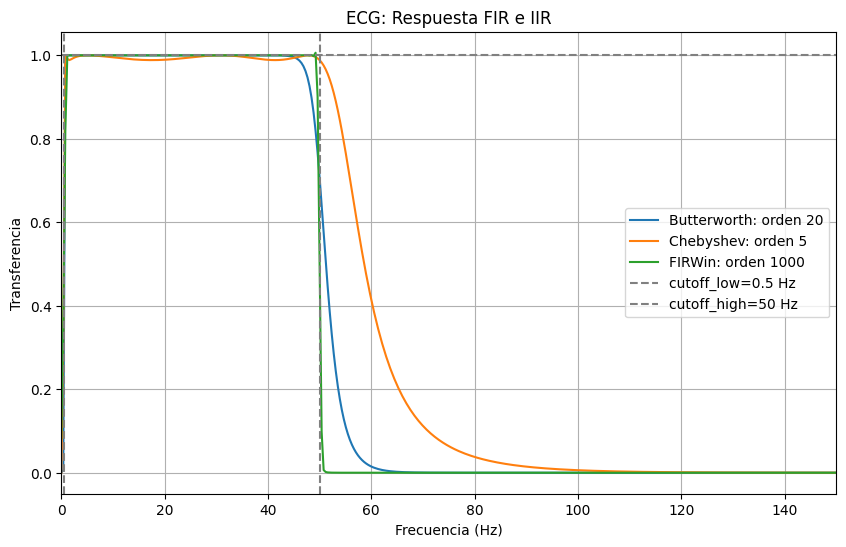

In [472]:
from scipy.signal import firwin, freqz, convolve
from scipy.signal import butter, lfilter, freqz, sosfilt, sosfreqz, sosfiltfilt

#Defino frecuencias de corte para el BPF
cutoff_low, cutoff_high = 0.5, 50
passband = [cutoff_low, cutoff_high]

#Orden de los filtros
filter_order_butter = 20
filter_order_cheby = 5
filter_order_FIR = 1000
numtaps = filter_order_FIR + 1

#Filtro Butterworth
sos = butter(N=filter_order_butter, Wn=passband, btype='band', fs=freq_muest, output='sos')
w, h_butter = sosfreqz(sos)

#Chebyshev
rp = 0.1  # Ruido permitido en la banda de paso
cheby_b, cheby_a = signal.cheby1(filter_order_cheby, rp, passband, analog=False, fs=freq_muest, btype='band')
w, h_cheby = signal.freqz(cheby_b, cheby_a)

#FIRWin
coefficients = firwin(numtaps, passband, fs=freq_muest, window='hann', pass_zero=False)
w, h_firwin = freqz(coefficients)

#Grafico los tres filtros para ver cual me da una mejor transferencia
w = w * (freq_muest / (2*np.pi))  # Para no tener las freq en rad/s

plt.figure(figsize=(10, 6))

plt.plot(w, np.abs(h_butter), label=f'Butterworth: orden {filter_order_butter}')
plt.plot(w, np.abs(h_cheby), label=f'Chebyshev: orden {filter_order_cheby}')
plt.plot(w, np.abs(h_firwin), label=f'FIRWin: orden {filter_order_FIR}')

plt.axvline(x=passband[0], linestyle='--', color='gray', label=f'cutoff_low={passband[0]} Hz')
plt.axvline(x=passband[1], linestyle='--', color='gray', label=f'cutoff_high={passband[1]} Hz')
plt.axhline(y=1, linestyle='--', color='gray')

plt.title('ECG: Respuesta FIR e IIR')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Transferencia')
plt.legend(loc='center right')
plt.xlim(0, 150)
plt.grid()
plt.show()


Se observa en el plot que el que mejor filtra la señal es el filtro FIRWin. Sin embargo, posee un inconveniente, y es que logra el filtrado de las componentes < 0.5Hz es necesario un orden alrededor de 1000, demandando un poder computacional muy grande que lo vuelve poco eficiente. Lo descartamos.

El Butterworth y el Chebyshev no sufren de este problema, presentando una respuesta adecuada en las banda de transición inferior. El filtro Chebyshev funciona unicamente hasta un orden 5, luego empieza a presentar Efecto Gibbs en la banda de transición inferior. Por lo tanto, nunca se logra la transición empinada, característica distintiva de este filtro.

El filtro Butterworth en cambio permite órdenes superiores sin presentar dicho efecto, solo "pagandolo" con una respuesta mas lenta.


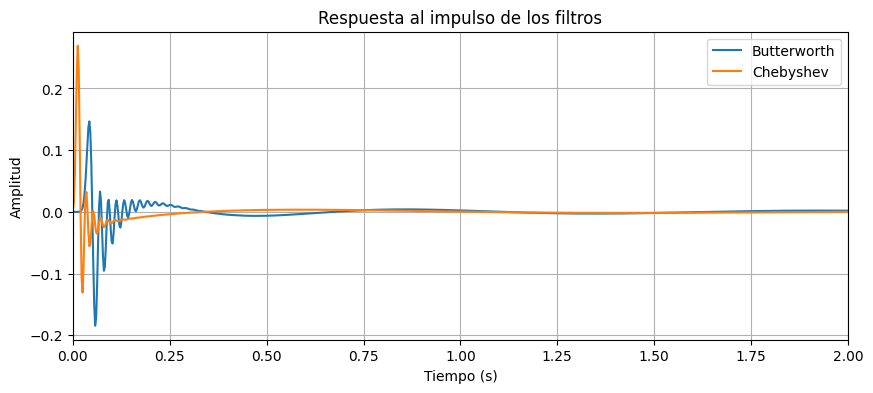

In [473]:
"""
Calculo la respuesta temporal al impulso de los dos filtros seleccionados
"""

# Armo funcion impulso en t
impulse = np.zeros_like(t)
impulse[0] = 1

# Obtengo respuesta temporal
h_impulse_butter = signal.sosfilt(sos, impulse)
h_impulse_cheby = signal.lfilter(cheby_b, cheby_a, impulse)

# Grafico de la respuesta al impulso de cada filtro
plt.figure(figsize=(10, 4))
plt.plot(t, h_impulse_butter, label='Butterworth')
plt.plot(t, h_impulse_cheby, label='Chebyshev')
plt.xlim(0, 2)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.title('Respuesta al impulso de los filtros')
plt.grid()
plt.legend()
plt.show()

Visualizando la respuesta al impulso se observa que el Butterworth tiene efectivamente una respuesta mas lenta, aunque la diferencia es poco significativa aún para sacar conclusiones.

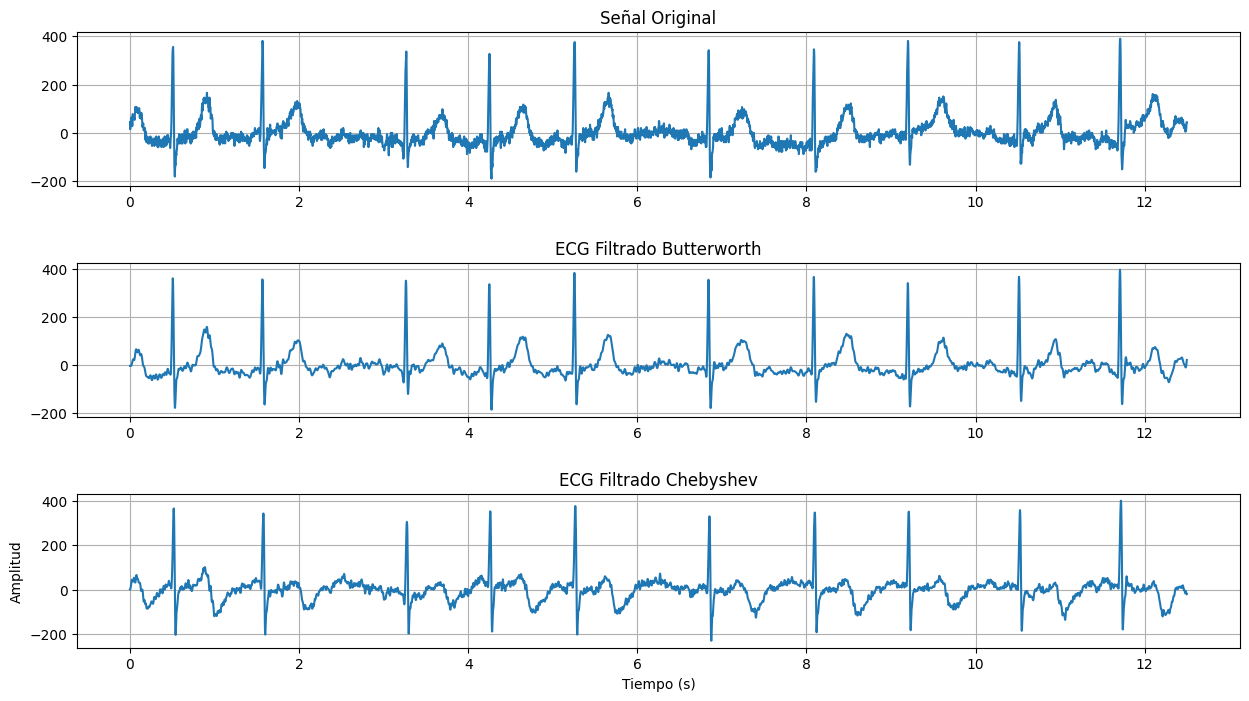

In [492]:
"""
Aplico los filtros al ECG
"""

filtered_ecg_butter = signal.sosfiltfilt(sos, ecg_signal)
filtered_ecg_cheby = signal.lfilter(cheby_b, cheby_a, ecg_signal)

plt.figure(figsize=(15, 8))

plt.subplot(3, 1, 1)
plt.plot(t, ecg_signal)
plt.title('Señal Original')
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(t, filtered_ecg_butter)
plt.title('ECG Filtrado Butterworth')
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(t, filtered_ecg_cheby)
plt.title('ECG Filtrado Chebyshev')
plt.grid()

plt.subplots_adjust(hspace=0.5)
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.show()

Ambos filtros disminuyen considerablemente el ruido de la señal, se observa que el Butterworth conserva mejor la integridad de la señal original, por lo que se continuará con este filtro.

***Nota: Observé algunos ECG que se parecen más a cómo da el Chebyshev, del punto de vista medicinal no sabría cuál es el indícado***

Comprobar con espectrograma y espectro de frecuencias si sigue habiendo alguna frecuencia no deseada, efectuar el filtro conveniente para eliminarla. Explicar por que eligen hacer lo que eligen hacer

52


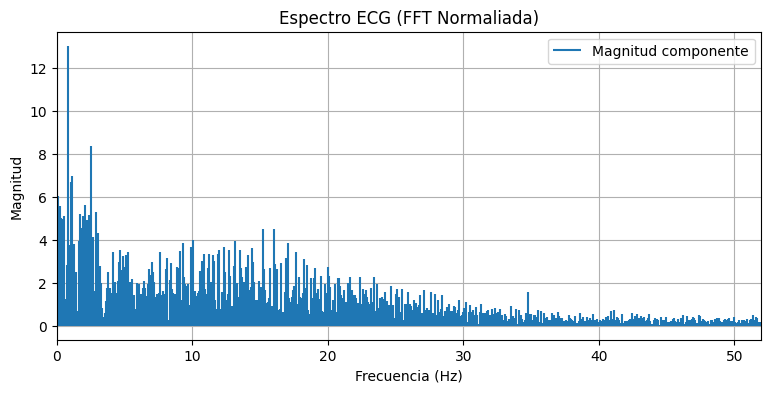

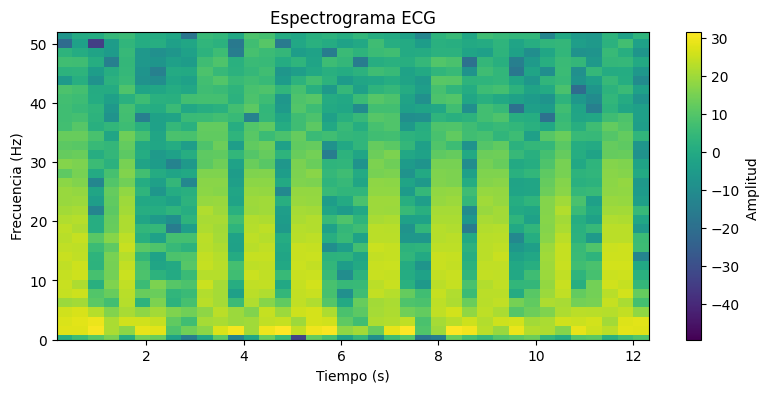

In [495]:
xlim = passband[1] + passband[1]//2   #Limites de plot que varian según la freq corte
ylim = xlim

print(xlim)

#Imprimo Espectro y Espectrograma
plot_fft(ecg_signal, cant_muest, dt, xlim)
plot_Sxx(ecg_signal, cant_muest, dt, ylim)

El filtrado de alta frecuencia se podría mejorar un poco más

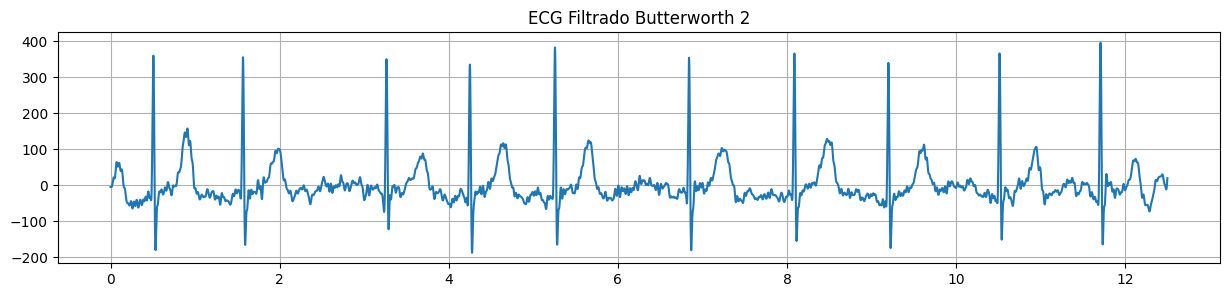

In [496]:
# Redefino frecuencias de corte
cutoff_low, cutoff_high = 0.5, 35
passband = [cutoff_low, cutoff_high]

# Obtengo transferencia del Butterworth
sos = butter(N=filter_order_butter, Wn=passband, btype='band', fs=freq_muest, output='sos')
w, h_butter = sosfreqz(sos)

#Respuesta temporal del filtro al ECG
filtered_ecg_butter_2 = signal.sosfiltfilt(sos, ecg_signal)
plt.figure(figsize=(15, 3))

plt.plot(t, filtered_ecg_butter_2)
plt.title('ECG Filtrado Butterworth 2')
plt.grid()

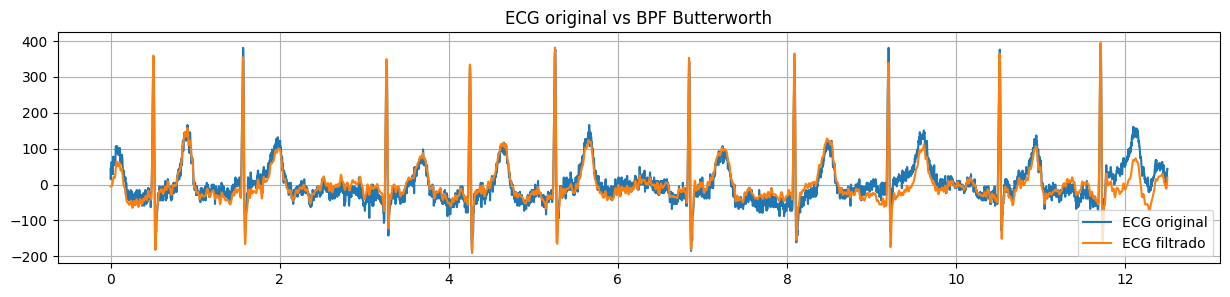

In [501]:
#Comparo vs el ECG original
plt.figure(figsize=(15, 3))
plt.plot(t, ecg_signal, label='ECG original')
plt.plot(t, filtered_ecg_butter_2, label='ECG filtrado')
plt.title('ECG original vs BPF Butterworth')
plt.grid()
plt.legend(loc='lower right')
plt.show()


Se logró disminuir considerablemnte el ruido, manteniendo la integridad de la señal.

Calcular la distancia R-R y detectar arritmias y sacar conclusiones.

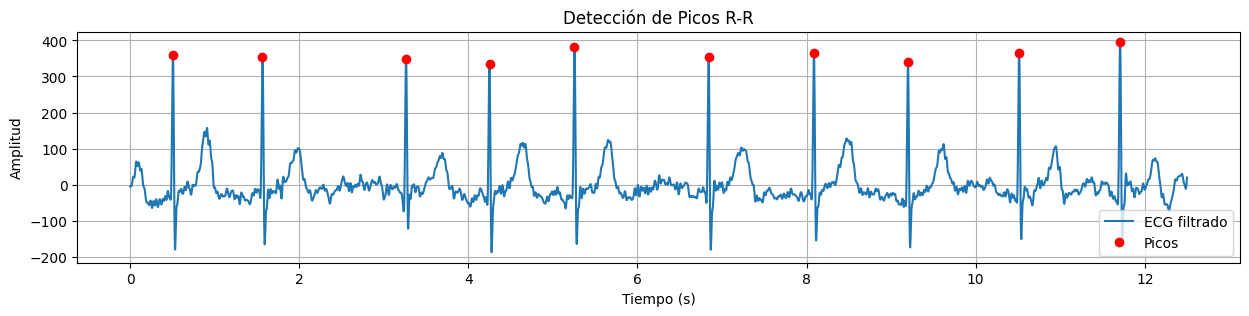

 Distancia entre picos 1 y 2: 1.06 segundos
 Distancia entre picos 2 y 3: 1.7 segundos
 Distancia entre picos 3 y 4: 0.99 segundos
 Distancia entre picos 4 y 5: 1.0 segundos
 Distancia entre picos 5 y 6: 1.58 segundos
 Distancia entre picos 6 y 7: 1.25 segundos
 Distancia entre picos 7 y 8: 1.11 segundos
 Distancia entre picos 8 y 9: 1.32 segundos
 Distancia entre picos 9 y 10: 1.2 segundos
La distancia promedio R-R es 1.24 segundos


In [478]:
from scipy.signal import find_peaks

#Obtengo picos
peaks, _ = find_peaks(filtered_ecg_butter_2, height=60, distance=200) #Distancia tal que me agarre solo los picos R

#Grafico señal y picos
plt.figure(figsize=(15, 3))
plt.plot(t, filtered_ecg_butter_2, label='ECG filtrado')
plt.plot(t[peaks], filtered_ecg_butter_2[peaks], 'ro', label='Picos')
plt.title('Detección de Picos R-R')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')

plt.legend()
plt.grid()
plt.legend(loc='lower right')
plt.show()

#Distancia entre los picos
for i in np.arange(0, len(peaks)-1):
  print(f' Distancia entre picos {i+1} y {i+2}: {round(np.abs(peaks[i+1]-peaks[i])/ freq_muest, 2)} segundos')

#Normalizo diferencias temporales y calculo distancia R-R
diff_temp = np.diff(peaks) / freq_muest
dist_rr = np.mean(diff_temp)
print(f'La distancia promedio R-R es {round(dist_rr, 2)} segundos')

Se observa una inconsistencia entre la distancias de los picos R entre los tiempos 2 y 5 aproximadamente. El paciente es arrítmico.

Calcular el promedio de las pulsaciones por minuto el paciente

In [479]:
#Calculo ppm tomando la media de las diff temp
ppm = np.mean(60 * freq_muest / np.diff(peaks))
print(f'El paciente tiene {round(ppm)} ppm')

El paciente tiene 50 ppm


Tiene que internarse 😔✌️

Calcular la frecuencia promedio de los picos R y mostrar en el espectro de frecuencias

La frecuencia promedio de los picos R es 0.8


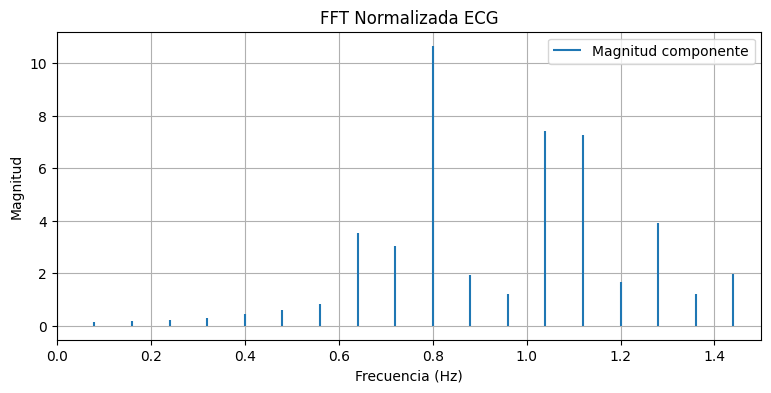

In [480]:
freq_prom = 1 / (np.mean(diff_temp))
xlim = round((2*freq_prom))
print(f'La frecuencia promedio de los picos R es {round(freq_prom, 2)}')
plot_fft(filtered_ecg_butter_2, cant_muest, dt, 1.5)


La frecuencia R-R es la frecuencia fundametal de la señal.

Hacer un espectrograma de la señal filtrada y explicar cómo se pueden ver en él cuantos picos R aparecen en cada intervalo de tiempo.

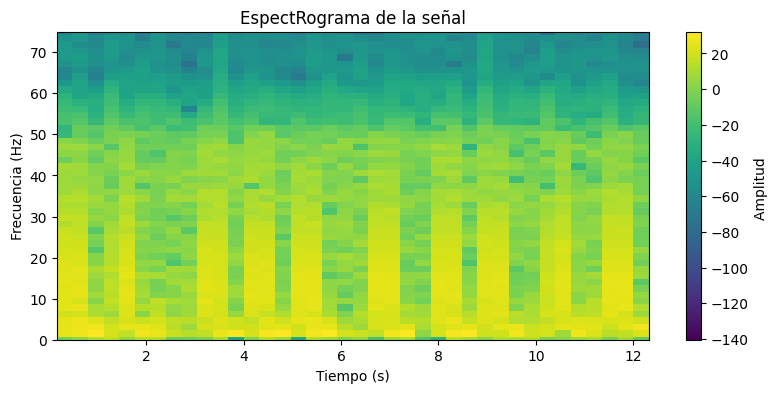

In [481]:
plot_Sxx(filtered_ecg_butter, cant_muest, dt, ylim)

Los picos R-R se pueden distinguir en cada barrido vertical amarillo, estos indican donde ocurre cada pico R en el ECG y que frecuencias son las responsables de estos. Las frecuencias mas bajas corresponden al intervalo ST.

**PARTE 2**

A la señal más 'limpia' que pudieron lograr de esta 1era parte hacerle una convolución con una ventana Gaussiana a elección, encontrar distancia R-R de este resultado y comparar con los resultados obtenidos en la parte 1. Evaluar pros y contras de este procedimiento.



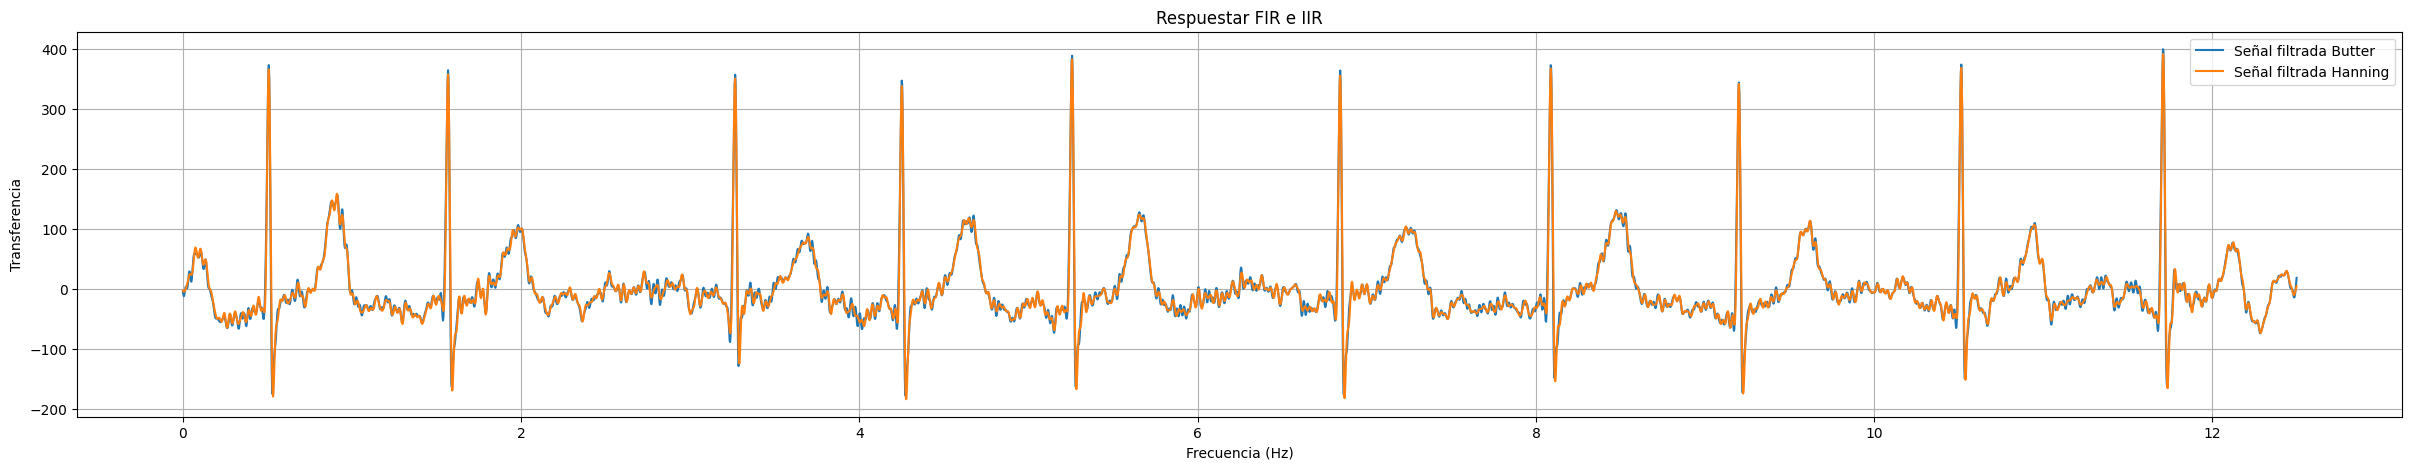

In [482]:
#FIRWIN
coefficients = firwin(10000, passband, fs=freq_muest, window='hann', pass_zero=False)
filtered_ecg_firwin = convolve(filtered_ecg_butter, coefficients, mode='same')

#Grafico los tres filtros para ver cual me da una mejor transferencia
plt.figure(figsize=(30, 5))
plt.plot(t, filtered_ecg_butter, label='Señal filtrada Butter')
plt.plot(t, filtered_ecg_firwin, label='Señal filtrada Hanning')

plt.title('Respuestar FIR e IIR')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('Transferencia')
plt.legend()
plt.grid()
plt.show()

No se si estoy entendiendo mal la consigna, pero no observo diferencias.

Tenía entendido que la convolución de una señal finita y una ventana en el dominio del tiempo es para eliminar el leakage en los bordes, lo cual no estaría viendo en el ECG.

**PARTE 3**

Elegir una ondita conveniente y hacer la transformada wavelet a la señal original con el nivel máx de descomposición. Explicar los motivos de la elección de dicha ondita comparandola con una que aproxime peor y mostrar resultados.

Luego, elegir los niveles que mejor se vean y **solo** con estos calcular la anti transformada ondita obteniendo otra señal que aproxima a la señal original


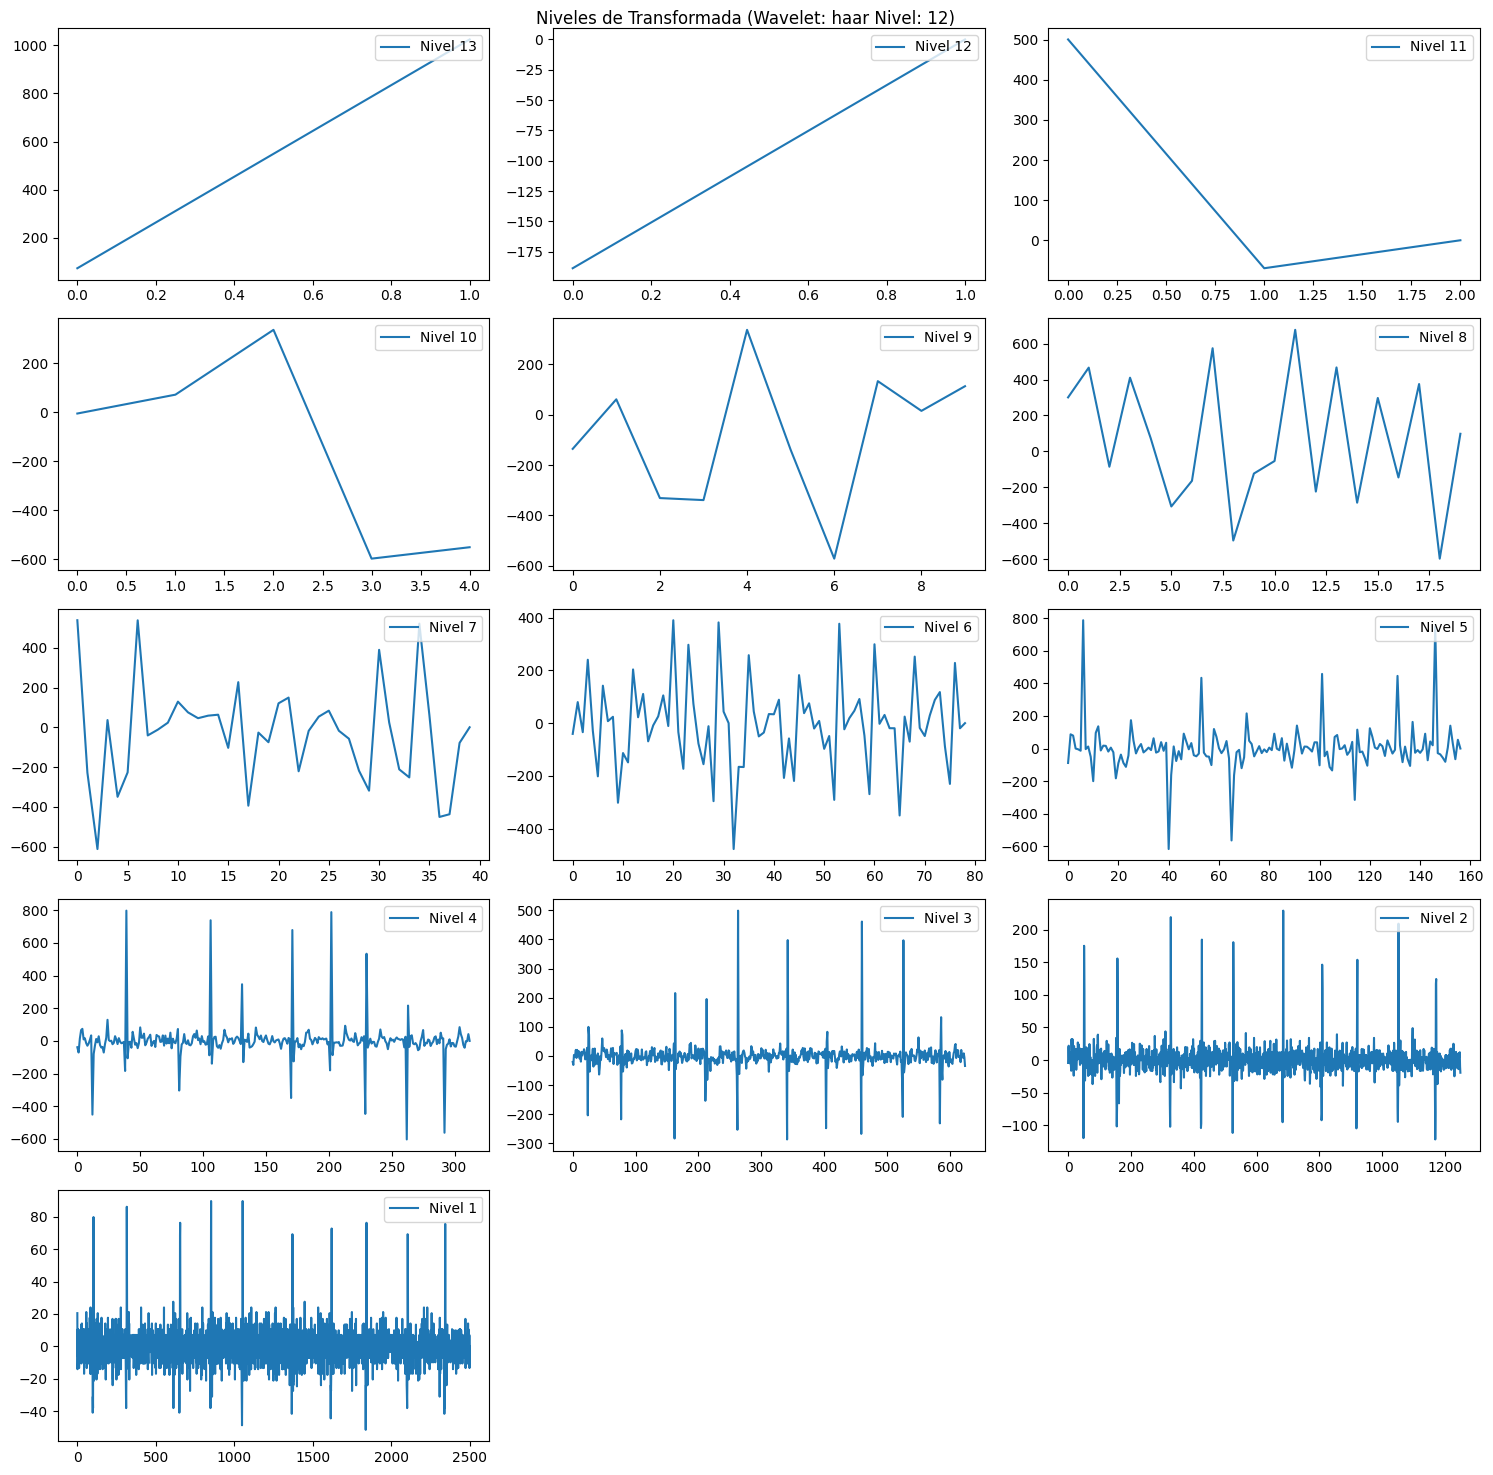

In [483]:
"""
Descompone una ECG en su Transformada Wavelet (haar) de maximo nivel e imprime todo los
niveles a partir de sus coeficientes.
"""

import pywt

# Calculo maximo nivel de descomposición y busco coeficientes
wav_haar = pywt.Wavelet('haar')
max_level_haar = pywt.dwt_max_level(len(ecg_signal), wav_haar.dec_len)
coeff_haar = pywt.wavedec(ecg_signal, wavelet = wav_haar, mode='per', level = max_level_haar)

# Establezco subplots de 3 columnas y filas dependientes de la cant de niveles
num_cols = 3
num_rows = (max_level_haar + 1) // num_cols + ((max_level_haar + 1) % num_cols > 0)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
axes = axes.flatten()

#Grafico Wavelet
for i in range (0, max_level_haar + 1):
  axes[i].plot(coeff_haar[i], label=f'Nivel {max_level_haar + 1 - i}')
  axes[i].legend(loc='upper right')

for j in range((num_rows * num_cols) - (max_level_haar + 1)):
  fig.delaxes(axes[max_level_haar + 1 + j])

fig.suptitle(f'Niveles de Transformada (Wavelet: {wav_haar.name} Nivel: {max_level_haar})')
plt.tight_layout()
plt.show()


Me quedo con los niveles del 4 al 10 para reconstruir la señal.

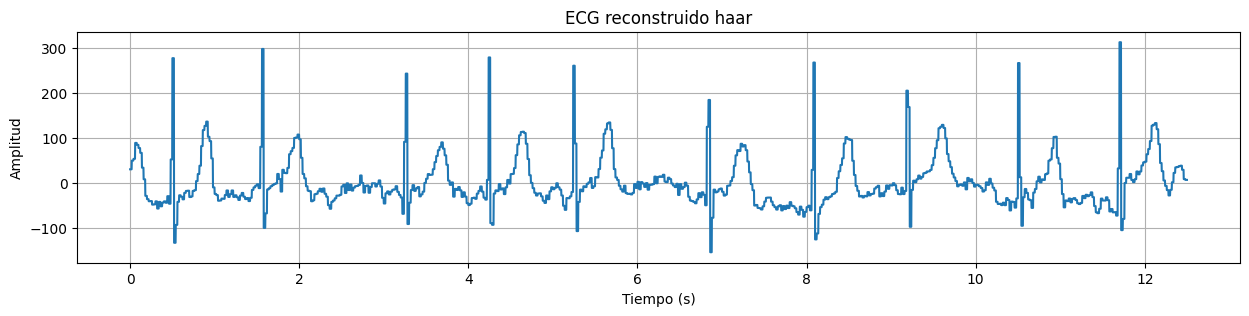

In [502]:
"""
Reconstruye la señal original a partir de los niveles seleccionados
"""

# Forma arreglo de niveles cero y los concatena
zeros_high = np.arange(0, 3, 1)  # Niveles 1, 2 y 3
zeros_low = np.arange(10, 13, 1)  # Niveles 10, 11 y 12
zero_levels = np.concatenate((zeros_high, zeros_low))

# Para no trabajar sobre los coeficientes originales
coeff_haar_rec = coeff_haar.copy()

# Hago ceros los niveles que quiero suprimir
for level in zero_levels:
  coeff_haar_rec[level] = np.zeros(len(coeff_haar_rec[level]))

# Reconstruyo la señal e imprimo
ecg_signal_haar = pywt.waverec(coeff_haar_rec, wav_haar)

plt.figure(figsize=(15, 3))
plt.plot(t, ecg_signal_haar)

plt.title('ECG reconstruido haar')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.show()

La señal reconstruida elimina elimina el ruido de alta frecuencia. Sin embargo, presenta una baja resolución, probablemente debido a la forma cuadrada de la wavelet haar. Hay que buscar una ventana mejor para este caso. Busco una wavelet discreta que se asemeje mas a una señal continua.

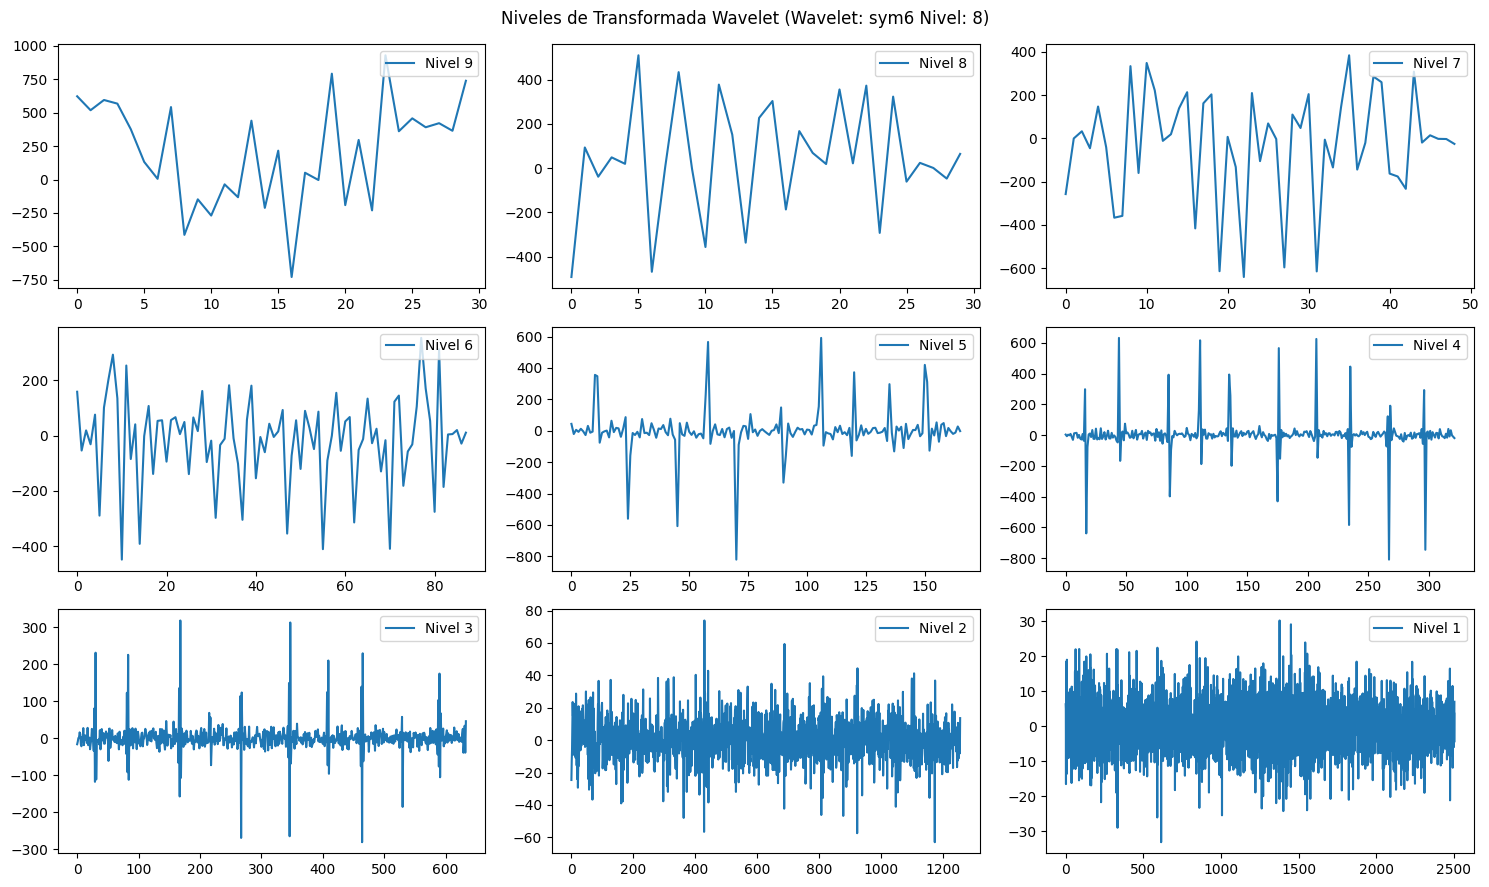

In [485]:
"""
Descompone una ECG en su Transformada Wavelet (sym6) de maximo nivel e imprime todo los
niveles a partir de sus coeficientes.
"""

wav_sym6 = pywt.Wavelet('sym6')

# Calculo maximo nivel de descomposición y busco coeficientes
max_level_sym6 = pywt.dwt_max_level(len(ecg_signal), wav_sym6.dec_len)

# Realizar la descomposición wavelet
coeff_sym6 = pywt.wavedec(ecg_signal, wavelet=wav_sym6, mode='sym', level=max_level_sym6)

# Configurar el diseño de los subgráficos
num_cols = 3
num_rows = (max_level_sym6+ 1) // num_cols + ((max_level_sym6+ 1) % num_cols > 0)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
axes = axes.flatten()

# Graficar los coeficientes de cada nivel de descomposición
for i in range(0, max_level_sym6+ 1):
    axes[i].plot(coeff_sym6[i], label=f'Nivel {max_level_sym6+ 1 - i}')
    axes[i].legend(loc='upper right')

# Ocultar subgráficos adicionales si es necesario
for j in range((num_rows * num_cols) - (max_level_sym6+ 1)):
    fig.delaxes(axes[max_level_sym6+ 1 + j])

fig.suptitle(f'Niveles de Transformada Wavelet (Wavelet: {wav_sym6.name} Nivel: {max_level_sym6})')
plt.tight_layout()
plt.show()

Me quedo con los niveles del 3 al 6

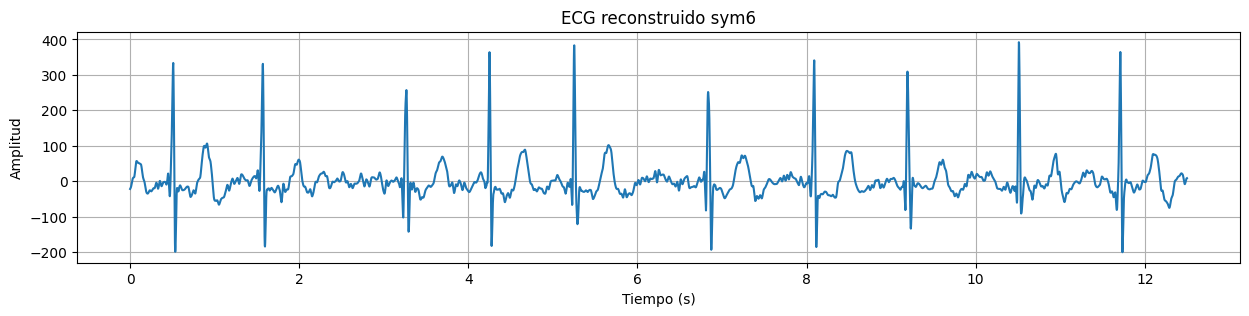

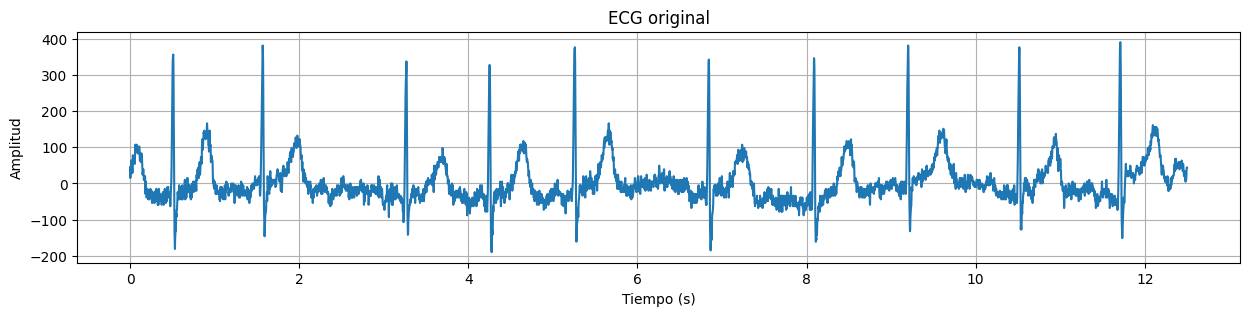

In [503]:
"""
Reconstruye la señal original a partir de los niveles seleccionados
"""

# Forma arreglo de niveles cero y los concatena
zeros_high = np.arange(0, 2, 1)  # Niveles 1 y 2
zeros_low = np.arange(6, 9, 1)  # Niveles 5, 6, 7 y 8
zero_levels = np.concatenate((zeros_high, zeros_low))

# Para no trabajar sobre los coeficientes originales
coeff_sym6_rec = coeff_sym6.copy()

# Hago ceros los niveles que quiero suprimir
for level in zero_levels:
  coeff_sym6_rec[level] = np.zeros(len(coeff_sym6_rec[level]))

# Reconstruyo la señal e imprimo
ecg_signal_sym6 = pywt.waverec(coeff_sym6_rec, 'sym6')

plt.figure(figsize=(15, 3))
plt.plot(t, ecg_signal_sym6)
plt.title('ECG reconstruido sym6')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.show()

plt.figure(figsize=(15, 3))

plt.plot(t, ecg_signal)
plt.title('ECG original')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.show()

La señal reconstruida es de mucha mayor resolución y presenta muy poco ruido. Por primera vez hasta el momento, se logran distinguir los intervalos PR, ST Y QT del ECG. Apenas presenta distorsión, solo resultando levemente atenuado el tercer pico R.

Calcular la distancia R-R de la señal encontarda en el punto anterior y comparar los resultados obtenidos con los obtenidos en la PARTE 1.

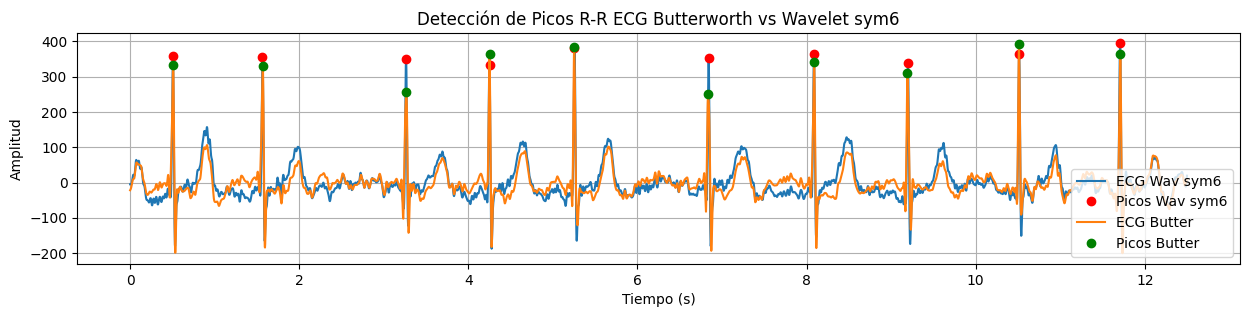

La distancia promedio R-R con Transformada Wavelet sym6 es 1.24 segundos
La distancia promedio R-R con filtrado Butterworth es 1.24 segundos


In [504]:
#Obtengo picos
peaks_sym6, _ = find_peaks(ecg_signal_sym6, height=60, distance=200) # Distancia tal que me agarre solo los picos R

#Grafico señal y picos ECG_sym6
plt.figure(figsize=(15, 3))

plt.plot(t, filtered_ecg_butter_2, label='ECG Wav sym6')
plt.plot(t[peaks], filtered_ecg_butter_2[peaks], 'ro', label='Picos Wav sym6')
plt.plot(t, ecg_signal_sym6, label='ECG Butter')
plt.plot(t[peaks_sym6], ecg_signal_sym6[peaks_sym6], 'go', label='Picos Butter')

plt.title('Detección de Picos R-R ECG Butterworth vs Wavelet sym6')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.legend(loc='lower right')
plt.show()

##Normalizo diferencias temporales y calculo distancia R-R
diff_temp_sym6 = np.diff(peaks_sym6) / freq_muest
dist_rr_sym6 = np.mean(diff_temp_sym6)
print(f'La distancia promedio R-R con Transformada Wavelet sym6 es {round(dist_rr_sym6, 2)} segundos')
print(f'La distancia promedio R-R con filtrado Butterworth es {round(dist_rr, 2)} segundos')




Las distancias entre pico son idénticas con una precisión de 2 decimales.

Comparar ambos procedimientos y sacar conclusiones, evaluando diferencias y similitudes.

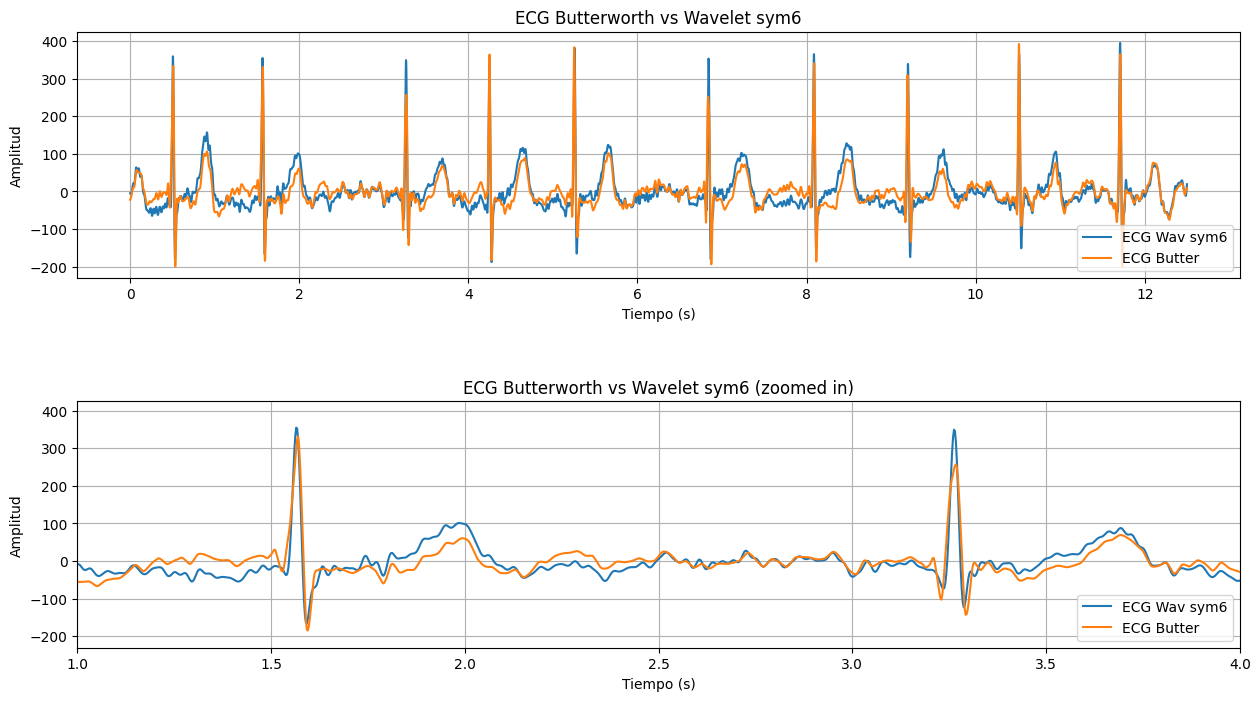

In [488]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(t, filtered_ecg_butter_2, label='ECG Wav sym6')
plt.plot(t, ecg_signal_sym6, label='ECG Butter')
plt.title('ECG Butterworth vs Wavelet sym6')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.grid()
plt.legend(loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(t, filtered_ecg_butter_2, label='ECG Wav sym6')
plt.plot(t, ecg_signal_sym6, label='ECG Butter')
plt.title('ECG Butterworth vs Wavelet sym6 (zoomed in)')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.xlim(1, 4)
plt.grid()

plt.subplots_adjust(hspace=0.5)
plt.legend(loc='lower right')
plt.show()

**Conclusiones**

Los dos procedimientos resultaron útiles para el filtrado de una señal de ECG.

El filtro Butterworth logró cumplir con los requerimientos principales, es decir limpiar la señal de ruido e interferencia manteniendo su integridad. Para los filtrados, fue necesario inspeccionar tanto el espectro como el espectrograma para identificar la contribución de cada frecuencia en cada momento temporal, luego fueron suprimidas las componentes no deseadas. El filtro resultante tuvo un comportamiento estable en la banda de paso y un nivel de pronunciamineto en las bandas de transición, manteniendo un orden relativamente bajo.

Por otro lado, con la Transformada Wavelet se logró un filtrado mucho mas satisfactorio, donde ademas de los segmentos R-R fue posible observar los segmentos PR, ST Y QT que caracterizan a un electrocardiograma. Descomponer la señal en Onditas -eligiendo el nivel de descomposición- otorogó una mayor libertad a fín de reconstruir la señal como se requería. Para una señal compuesta por varias componentes espectrales, resultó un método adecuado. Como contrapartidas, a comparación del Butterworth resultaría tedioso eliminar algún rango pequeño de frecuencias en particular, como tambien implementarlo para trabajar con señales mas sencillas. Además, es fundamental elegir una wavelet que se adapte correctamente a la función.

En conclusión, si bien ambos métodos fueron satisfactorios para limpiar la señal ECG y llevar a cabo las lecturas solicitadas, el filtrado mediante Transformada Wavelet resultó ser el más versatil.